$$\begin{cases}
    y'' + \sin{y} = 0, 0 \le x \le 3 \\
    y(0) = 0, y(3) = \pi
\end{cases}$$

Это уравнение можно свести к системе

$$\begin{cases}
    y' = u \\
    u' = -\sin{y}, 0 \le x \le 3 \\
    y(0) = 0, y(3) = \pi
\end{cases}$$

Которая имеет первый интеграл

$$C(y, u) = u^2 - 2\cos{y}$$

Его и будем использовать для проверки точности решения

In [ ]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from ODElib import *
from math import *

def f(x : float, y : Vector, dy : float):
    return -sin(y)

def C(y : Vector):
    return y[1]*y[1] - 2*cos(y[0])

FuncT2D = Callable[[float, float, float], float]

# y'' = f(x, y, y')
# y(x1) = y1
# y(x1 + Nh) = y2
class BVPSolver:
    eps = 1e-9
    step = 1e-7

    # u'' + A(x)u' + B(x)u = 0
    # u0 = 0, u0' = 1
    @staticmethod
    def __solve_linear(A : Callable[[int], float], B : Callable[[int], float], h : float, N : int):
        u = [0.0, (2 + A(1)*h) / (2 - B(1)*h*h) * h, 2 * h]
        for n in range(2, N):
            u += [(2 * (2 - B(n)*h*h)*u[n] - (2 - A(n)*h)*u[n-1]) / (2 + A(n)*h)]
        return u

    @staticmethod
    def solve_by_shooting_method(f : FuncT2D, h : float, N: int, y1 : float, y2 : float, x1 : float = 0):
        g : VecTFunc = lambda x, q: Vector(q[1], f(x, q[0], q[1]))
        alpha = 0
        step = BVPSolver.step
        while(True):
            probe = RungeKuttaMethods.explicit_4_order(g, Vector(y1, alpha), h, N, x1)
            boundary = probe[N][0] - y2
            ODEIOSettings.info("Boundary vlaue: " + str(probe[N][0]))
            if(abs(boundary) < BVPSolver.eps):
                break
            A = lambda n: (f(n*h, probe[n][0] - step, probe[n][1]) - f(n*h, probe[n][0] + step, probe[n][1])) / (2 * step)
            B = lambda n: (f(n*h, probe[n][0], probe[n][1] - step) - f(n*h, probe[n][0], probe[n][1] + step)) / (2 * step)
            alpha = alpha - boundary / BVPSolver.__solve_linear(A, B, h, N)[N]
        return RungeKuttaMethods.explicit_4_order(g, Vector(y1, alpha), h, N, x1)
    
    @staticmethod
    def solve_by_quasilinearization_method(f : FuncT2D, h : float, N: int, y1 : float, y2 : float, x1 : float = 0):
        pass

def show_result(N : int, us : list[Vector], h : float):
    xs = [h*k for k in range(N + 1)]
    fig = plt.figure(figsize=[6,8])
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    fig.add_subplot(gs[0])
    plt.plot(xs, [us[k][0] for k in range(N + 1)])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(r"$y'' + \sin{y} = 0, y(0) = 0, y(3) = \pi$")
    ax = fig.add_subplot(gs[1])
    plt.plot(xs, [C(us[k]) - C(us[-1]) for k in range(N + 1)], "--", label="C(y(x), y'(x)) - C(y(3), y'(3))", color="orange")
    formatter = ScalarFormatter(useMathText=True, useOffset=False)
    ax.yaxis.set_major_formatter(formatter)
    plt.legend()

N = 1000
h = 3 / N

# Метод стрельбы

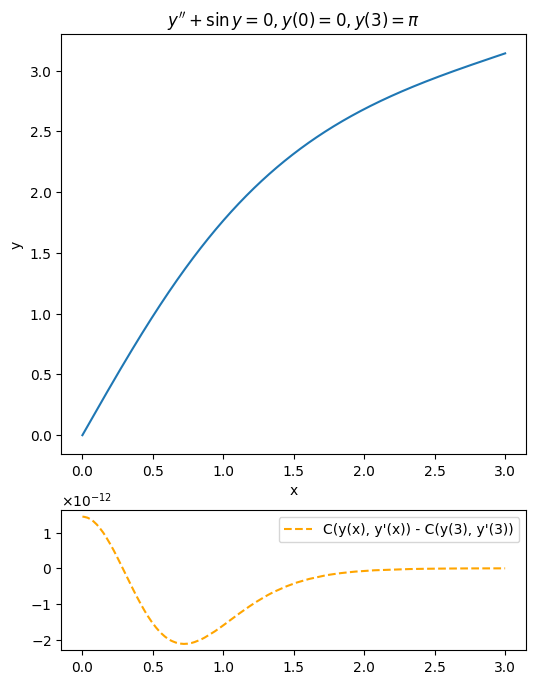

In [24]:
show_result(N, BVPSolver.solve_by_shooting_method(f, h, N, 0, pi), h)

# Метод квазилинеаризации Ньютона

In [ ]:
show_result(N, BVPSolver.solve_by_quasilinearization_method(f, h, N, 0, pi), h)